In [1]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:
############### upload data
# Mount Google drive to load data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd

path ='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/new_processed_data/test.csv'

text_data = pd.read_csv(path, sep=',')
print(text_data)
print(text_data["toxic"].value_counts())

                    id  ... identity_hate
0     6d5688fab66073c6  ...             1
1     64fc056641dba716  ...             0
2     ff5c60747f023cbd  ...             0
3     d4e23c86f5b1d708  ...             1
4     9a9dc24ba68e7597  ...             0
...                ...  ...           ...
3022  0cf27594013bb708  ...             0
3023  c04d00a14a202a94  ...             0
3024  b00ced343a0c5d8b  ...             1
3025  6ae73417bb0c7b61  ...             0
3026  fcda70fcb02196ce  ...             1

[3027 rows x 8 columns]
1    2491
0     536
Name: toxic, dtype: int64


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext import data
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import argparse
import os
import datetime, time

In [5]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_LSTM(nn.Module):
    def __init__(self, embedding_dim, vocab, hidden_dim=100):
        super(CNN_LSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.hidden_dim = hidden_dim

        self.conv1 = nn.Conv2d(1, 100,kernel_size=(2,embedding_dim)) #in_channels, out_chanels, kernel_size
        
        
        self.lstm1 = nn.LSTM(embedding_dim,hidden_dim)
        target_size = 1
        self.fc1 = nn.Linear(hidden_dim, target_size)

    def forward(self, x, lengths):
    #   embeds = self.word_embeddings(sentence)
    #     lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
    #     tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
    #     tag_scores = F.log_softmax(tag_space, dim=1)
    #     return tag_scores
        
        x = self.embedding(x)
        # print('x.shape',x.shape)

        x = x.unsqueeze(0)
        # print('x = x.unsqueeze(0)',x.shape)
        x = x.transpose(1,2) # swaps 2nd and 3rd dimension
        # print('x = x.transpose(1,2)',x.shape)
        x = x.transpose(0,1) # swaps 1st and 2nd dimension, now it has the correct input (n_samples,channels, height, width)
        # print('x = x.transpose(0,1)',x.shape)
        x1 = F.relu(self.conv1(x)) 
        # print('x1 = F.relu(self.conv1(x))',x1.shape)
        
        x1 = x1.squeeze(3)
        # print('x1 = x1.squeeze(3)',x1.shape)
        pool1 = nn.MaxPool1d(x1.size(2), 1) #maxpool
        
        x = pool1(x1)
        # print('pool1 = nn.MaxPool1d(x1.size(2), 1)',x.shape)
        x = x.squeeze(2)
        x = x.unsqueeze(0)
        # print('x = x.squeeze(2)',x.shape)


        #  pack the word embeddings in the batch together and 
        # run the RNN on this object
        # x = pack_padded_sequence(x,lengths) 
        # print('x.shape',x.shape)
        x,(h,c) = self.lstm1(x)
        # print('x.shape',x.shape)
        # print('h.shape',h.shape)
        # print('len(h)',len(h))
        # print('(x.view(len(lengths),-1)).shape',(x.view(len(lengths),-1)).shape)
        h_result = self.fc1(h.squeeze(0))
        # h_result = F.log_softmax(tag_space, dim=1) --> change to this with multiple cat
        h_result = torch.sigmoid(h_result)
        

        return h_result.squeeze(1)

## train

epoch---------------------------------------------- 0
cat ['toxic', 'severe_toxic']
[1] toxic_train loss: 0.494, toxic_train acc: 0.819, toxic_validation loss: 0.399, toxic_validation acc: 0.915,         toxic_testing loss: 0.422, toxic_testing acc: 0.892 
[1] threat_train loss: 0.702, threat_train acc: 0.710, threat_validation loss: 0.692, threat_validation acc: 0.280,        threat_testing loss: 0.693, threat_testing acc: 0.265 
[1] comb_train loss: 0.598, comb_train acc: 0.533, comb_validation loss: 0.546, comb_validation acc: 0.535,        comb_testing loss: 0.557, comb_testing acc: 0.528  
epoch---------------------------------------------- 1
cat ['toxic', 'severe_toxic']
[2] toxic_train loss: 0.490, toxic_train acc: 0.823, toxic_validation loss: 0.399, toxic_validation acc: 0.915,         toxic_testing loss: 0.422, toxic_testing acc: 0.892 
[2] threat_train loss: 0.693, threat_train acc: 0.714, threat_validation loss: 0.693, threat_validation acc: 0.280,        threat_testing los

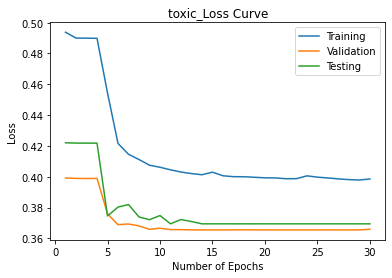

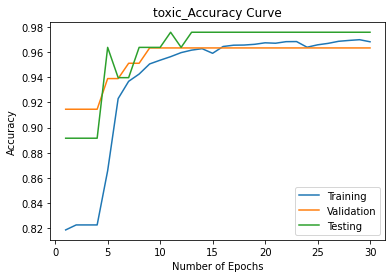

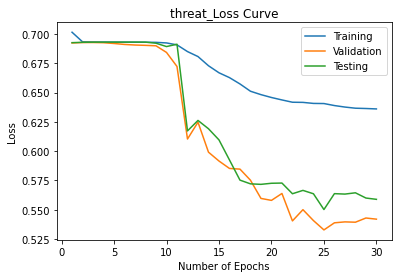

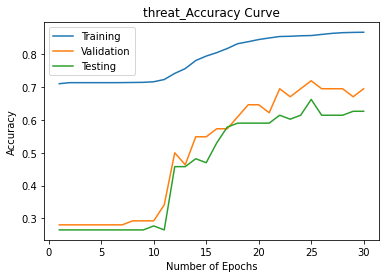

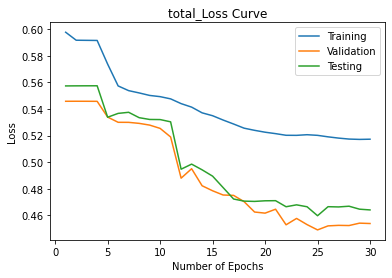

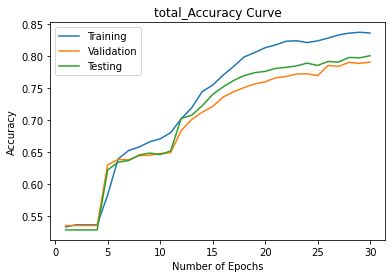

In [14]:
trainRNN_R(seed = 0, batch_size = 128, learning_rate = 0.001, epochs = 30, model = CNN_LSTM, emb_dim = 100, rnn_hidden_dim = 100, num_filt = 50)

In [7]:
def trainRNN_R(seed = 0, batch_size = 64, learning_rate = 0.001, epochs = 25, model = CNN_LSTM, emb_dim = 100, rnn_hidden_dim = 100, num_filt = 50):
    
  torch.manual_seed(seed)

  COMMENT_TEXT    = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
  TOXIC           = data.Field(sequential=False, use_vocab=False)
  SEVERE_TOXIC    = data.Field(sequential=False, use_vocab=False)
  OBSCENE         = data.Field(sequential=False, use_vocab=False)
  THREAT          = data.Field(sequential=False, use_vocab=False)
  INSULT          = data.Field(sequential=False, use_vocab=False)
  IDENTITY_HATE   = data.Field(sequential=False, use_vocab=False)

  train_data, val_data, test_data = data.TabularDataset.splits(
          path='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/new_processed_data/', train='train.csv',
          validation='valid.csv', test='test.csv', format='csv',
          skip_header=True, fields=[('id', None), ('text', COMMENT_TEXT), ('toxic', TOXIC), ('severe_toxic', SEVERE_TOXIC), ('obscene', OBSCENE), ('threat', THREAT), ('insult', INSULT), ('identity_hate', IDENTITY_HATE)])
          # path='/content/drive/MyDrive/ece367/ECE324 project/dataProcessing/multi_loose_large_data/', train='train.csv',
          # validation='valid.csv', test='test.csv', format='csv',
          # skip_header=True, fields=[('id', None), ('text', COMMENT_TEXT), ('toxic', TOXIC), ('severe_toxic', SEVERE_TOXIC), ('obscene', OBSCENE), ('threat', THREAT), ('insult', INSULT), ('identity_hate', IDENTITY_HATE)])
          
  train_iter, val_iter, test_iter = data.BucketIterator.splits(
      (train_data, val_data, test_data), batch_sizes=(batch_size, batch_size,batch_size),
      sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)

  COMMENT_TEXT.build_vocab(train_data, val_data, test_data)

  COMMENT_TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=100))
  vocab = COMMENT_TEXT.vocab
  cat = ['toxic','severe_toxic']

  train_classifier(cat,vocab,train_iter, val_iter, test_iter,seed, learning_rate, epochs, model, emb_dim, rnn_hidden_dim, num_filt) 
  
  # train_classifier(cat = 'toxic', vocab=vocab, train_iter=train_iter, val_iter=val_iter, test_iter=test_iter,seed = , 
                  #  learning_rate = 0.001, epochs = 25, model = CNN_LSTM, emb_dim = 100, rnn_hidden_dim = 100, num_filt = 50)


  

In [12]:
def batch_label(batch, cat):
    if cat == 'toxic':
      return batch.toxic.float() 
    elif cat == 'severe_toxic':
      return batch.severe_toxic.float() 
    elif cat == 'obscene':
      return batch.obscene.float() 
    elif cat == 'threat':
      return batch.threat.float() 
    elif cat == 'insult':
      return batch.insult.float() 
    elif cat == 'identity_hate':
      return batch.identity_hate.float() 
    else:
      print("ERROR: wrong category name")

def get_binary_accuracy(model,batch_input,batch_input_length,learning_rate,labels):  
    valCorrect = 0
    valRunningLoss = 0.0
    valNumberOfBatches = 0
    valTotal = 0
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    outputs = model(batch_input, batch_input_length)

    loss = criterion(outputs, labels)
    valRunningLoss += loss.item()
    outputs = (outputs>0.5).float()
    
    valCorrect += (outputs == labels).sum().item()
    valTotal += labels.size(0)
    # print('valTotal += labels.size(0)',valTotal)
    valNumberOfBatches += 1
    valRunningLoss = valRunningLoss/valNumberOfBatches
    valCorrect = valCorrect/valTotal

    return valRunningLoss,valCorrect,outputs,valTotal
    

def evaluate_combined_correct(toxic_outputs,toxic_labels,threat_outputs,threat_labels):
    comb_correct = 0
    comb_outputs = torch.cat((toxic_outputs.unsqueeze(0), threat_outputs.unsqueeze(0)),0)
    comb_outputs = torch.transpose(comb_outputs, 0, 1)
    # print('##############')
    # print('comb_outputs',comb_outputs)
    # print('comb_outputs shape',comb_outputs.shape)

    comb_labels = torch.cat((toxic_labels.unsqueeze(0), threat_labels.unsqueeze(0)),0)
    comb_labels = torch.transpose(comb_labels, 0, 1)
    # print('comb_labels',comb_labels)
    # print('comb_labels shape',comb_labels.shape)
    # print('##############')
    temp = (comb_labels == comb_outputs)
    for i in temp:
      # print(temp)
      if torch.equal(i, torch.BoolTensor([True, True])):
        comb_correct += 1
    # print('comb_correct',comb_correct)
    # print('##############')
    return comb_correct


def evaluate_binary_loss_correct(data_iter,toxic_model,threat_model,cat,learning_rate):
    val_comb_correct = 0
    valTotal = 0

    with torch.no_grad():
      for batch in data_iter:
        batch_input, batch_input_length = batch.text
        
        toxic_valLabels = batch_label(batch,cat[0])  
        threat_valLabels = batch_label(batch,cat[1])  

        toxic_valRunningLoss,toxic_valCorrect,toxic_valOutputs,val_batch_total = get_binary_accuracy(toxic_model,batch_input,batch_input_length,learning_rate,toxic_valLabels)
        threat_valRunningLoss,threat_valCorrect,threat_valOutputs,val_batch_total = get_binary_accuracy(threat_model,batch_input,batch_input_length,learning_rate,threat_valLabels)

        val_comb_correct += evaluate_combined_correct(toxic_valOutputs,toxic_valLabels,threat_valOutputs,threat_valLabels)
        valTotal += val_batch_total
    # print statistics for every epoch)
    # print('///////// val total 1//////////',valTotal)
    return toxic_valRunningLoss,toxic_valCorrect,threat_valRunningLoss,threat_valCorrect,val_comb_correct,valTotal


def train_classifier(cat ,vocab,train_iter, val_iter, test_iter,seed, learning_rate, epochs, model, emb_dim, rnn_hidden_dim, num_filt): 
    torch.manual_seed(seed)
    
    toxic_model = model(emb_dim, vocab)
    toxic_criterion = nn.BCEWithLogitsLoss()
    toxic_optimizer = optim.Adam(toxic_model.parameters(), lr=learning_rate)
    
    threat_model = model(emb_dim, vocab)
    threat_criterion = nn.BCEWithLogitsLoss()
    threat_optimizer = optim.Adam(threat_model.parameters(), lr=learning_rate)
    

    
    toxic_lossCount = []
    toxic_accCount = []
    
    threat_lossCount = []
    threat_accCount = []

    toxic_valLossCount = []
    toxic_valAccCount = []

    threat_valLossCount = []
    threat_valAccCount = []

    toxic_testLossCount = []
    toxic_testAccCount = []

    threat_testLossCount = []
    threat_testAccCount = []

    # testLossCount = []
    # testAccCount = []
    epochCount = []  
    
    total_prediction_train_accuracy = []
    total_prediction_val_accuracy = []
    total_prediction_test_accuracy = []

    total_prediction_train_loss = []
    total_prediction_val_loss = []
    total_prediction_test_loss = []

    
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        print('epoch----------------------------------------------',epoch)
        toxic_correct = 0
        toxic_total = 0
        toxic_runningLoss = 0.0
        toxic_numberOfBatches = 0

        threat_correct = 0
        threat_total = 0
        threat_runningLoss = 0.0
        threat_numberOfBatches = 0

        val_total = 0
        test_total = 0

        comb_correct = 0
        val_comb_correct = 0
        test_comb_correct = 0
        
        
        for i, batch in enumerate(train_iter, 0):
            # print('i',i)
            # get the set of text sentences in the batch and length of the sentence sequences
            batch_input, batch_input_length = batch.text
            ########### toxic #################################################
            toxic_labels = batch_label(batch,cat[0]) 
            # print('toxic_labels',toxic_labels)
        
            # zero the parameter gradients
            toxic_optimizer.zero_grad()

            # forward + backward + optimize
            toxic_outputs = toxic_model(batch_input, batch_input_length)
            toxic_loss = toxic_criterion(toxic_outputs, toxic_labels)
            toxic_loss.backward()
            toxic_optimizer.step()
            ########### toxic #################################################


          # ########## threat #############################################
            threat_labels = batch_label(batch,cat[1]) 
        
            # zero the parameter gradients
            threat_optimizer.zero_grad()
            # print('threat_labels',threat_labels)
            # forward + backward + optimize
            threat_outputs = threat_model(batch_input, batch_input_length)
            # print('outputs',threat_outputs)
            threat_loss = threat_criterion(threat_outputs, threat_labels)
            # print('threat_outputs',threat_outputs)
            # print('threat_loss',threat_loss)

            threat_loss.backward()
            threat_optimizer.step()
            #### threat ####################################################
            
            ##### evaluate training accuracy ###############################
            with torch.no_grad():
              toxic_outputs = (toxic_outputs>0.5).float()
              # print('changed_out',toxic_outputs)
              toxic_correct += (toxic_outputs == toxic_labels).sum().item()
              # print('toxic_correct',toxic_correct)
              # print('toxic_outputs train',toxic_outputs)
            
              threat_outputs = (threat_outputs>0.5).float()
              #   # print('threat_outputs_changed',threat_outputs)
              threat_correct += (threat_outputs == threat_labels).sum().item()
              

              comb_correct += evaluate_combined_correct(toxic_outputs,toxic_labels,threat_outputs,threat_labels)           
              
              ##### evaluate training accuracy ###############################    
            
            # add training loss
            # print('toxic_loss',toxic_loss)
            toxic_runningLoss += toxic_loss.item()
            # print('toxic_runningLoss',toxic_runningLoss)

            # count the number of batches and samples
            toxic_numberOfBatches += 1
            toxic_total += toxic_labels.size(0)


            # # evaluate training accuracy
            # with torch.no_grad():
            #   threat_outputs = (threat_outputs>0.5).float()
            #   # print('threat_outputs_changed',threat_outputs)
            #   threat_correct += (threat_outputs == threat_labels).sum().item()
            
            # add training loss
            # print('threat_loss',threat_loss)
            threat_runningLoss += threat_loss.item()
            # print('threat_runningLoss',threat_runningLoss)

            # count the number of batches and samples
            threat_numberOfBatches += 1
            threat_total += threat_labels.size(0)
        # print('threat_total',threat_total)
        # print('toxic_total',toxic_total)
        
        toxic_runningLoss = toxic_runningLoss/toxic_numberOfBatches
        toxic_correct = toxic_correct/toxic_total

        threat_runningLoss = threat_runningLoss/threat_numberOfBatches
        threat_correct = threat_correct/threat_total

        
        epochCount += [epoch+1]
        
        toxic_lossCount += [toxic_runningLoss]
        toxic_accCount += [toxic_correct]

        threat_lossCount += [threat_runningLoss]
        threat_accCount += [threat_correct]
        
        total_prediction_train_loss += [(toxic_runningLoss+threat_runningLoss)/2]
        total_prediction_train_accuracy += [comb_correct/threat_total]

        ######### validation dataset ###################################
        # cat = ['toxic','identity_hate']
        print('cat',cat)
        toxic_valRunningLoss,toxic_valCorrect,threat_valRunningLoss,threat_valCorrect,val_comb_correct,val_total = evaluate_binary_loss_correct(val_iter,toxic_model,threat_model,cat,learning_rate)
        total_prediction_val_loss += [(toxic_valRunningLoss+threat_valRunningLoss)/2]
        total_prediction_val_accuracy += [val_comb_correct/val_total]

        toxic_valLossCount += [toxic_valRunningLoss]
        toxic_valAccCount += [toxic_valCorrect]

        threat_valLossCount += [threat_valRunningLoss]
        threat_valAccCount += [threat_valCorrect]
        ######### validation dataset ###################################
        
        ######### testing dataset ###################################
        toxic_testRunningLoss,toxic_testCorrect,threat_testRunningLoss,threat_testCorrect,test_comb_correct,test_total = evaluate_binary_loss_correct(test_iter,toxic_model,threat_model,cat,learning_rate)
        
        total_prediction_test_loss += [(toxic_testRunningLoss+threat_testRunningLoss)/2]
        total_prediction_test_accuracy += [test_comb_correct/test_total]

        toxic_testLossCount += [toxic_testRunningLoss]
        toxic_testAccCount += [toxic_testCorrect]

        threat_testLossCount += [threat_testRunningLoss]
        threat_testAccCount += [threat_testCorrect]   
                
        

        print('[%d] toxic_train loss: %.3f, toxic_train acc: %.3f, toxic_validation loss: %.3f, toxic_validation acc: %.3f, \
        toxic_testing loss: %.3f, toxic_testing acc: %.3f ' %
                      (epoch + 1, toxic_runningLoss, toxic_correct,toxic_valRunningLoss, toxic_valCorrect,toxic_testRunningLoss,toxic_testCorrect))
        
        print('[%d] threat_train loss: %.3f, threat_train acc: %.3f, threat_validation loss: %.3f, threat_validation acc: %.3f,\
        threat_testing loss: %.3f, threat_testing acc: %.3f ' %
                      (epoch + 1, threat_runningLoss, threat_correct, threat_valRunningLoss, threat_valCorrect,threat_testRunningLoss,threat_testCorrect))
        
        print('[%d] comb_train loss: %.3f, comb_train acc: %.3f, comb_validation loss: %.3f, comb_validation acc: %.3f,\
        comb_testing loss: %.3f, comb_testing acc: %.3f  ' %
                      (epoch + 1, (toxic_runningLoss+threat_runningLoss)/2, comb_correct/threat_total,\
                       (toxic_valRunningLoss+threat_valRunningLoss)/2,val_comb_correct/val_total,\
                       (toxic_testRunningLoss+threat_testRunningLoss)/2,test_comb_correct/test_total))
        
        
        
        

        

    # testCorrect = 0
    # testRunningLoss = 0.0
    # testNumberOfBatches = 0
    # testTotal = 0
    # with torch.no_grad():
    #       for batch in test_iter:
    #         batch_input, batch_input_length = batch.text
            
    #         labels = batch_label(batch,cat) 

    #         outputs = model(batch_input, batch_input_length)
    #         loss = criterion(outputs, labels)
    #         testRunningLoss += loss.item()
    #         outputs = (outputs>0.5).float()
    #         testCorrect += (outputs == labels).sum().item()
    #         testTotal += labels.size(0)
    #         testNumberOfBatches += 1
    #       testRunningLoss = testRunningLoss/testNumberOfBatches
    #       testLossCount += [testRunningLoss]
    #       testAccCount += [testCorrect]
    # print('Finished Training. Test accuracy is %.3f and loss is %.3f' % (testCorrect/testTotal, testRunningLoss))

    #plot
    plt.title("toxic_Loss Curve")
    plt.plot(epochCount, toxic_lossCount, label="Training")
    plt.plot(epochCount, toxic_valLossCount, label="Validation")
    plt.plot(epochCount, toxic_testLossCount, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


    plt.title("toxic_Accuracy Curve")
    plt.plot(epochCount, toxic_accCount, label = "Training")
    plt.plot(epochCount, toxic_valAccCount, label = "Validation")
    plt.plot(epochCount, toxic_testAccCount, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("threat_Loss Curve")
    plt.plot(epochCount, threat_lossCount, label="Training")
    plt.plot(epochCount, threat_valLossCount, label="Validation")
    plt.plot(epochCount, threat_testLossCount, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


    plt.title("threat_Accuracy Curve")
    plt.plot(epochCount, threat_accCount, label = "Training")
    plt.plot(epochCount, threat_valAccCount, label = "Validation")
    plt.plot(epochCount, threat_testAccCount, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("total_Loss Curve")
    plt.plot(epochCount, total_prediction_train_loss, label="Training")
    plt.plot(epochCount, total_prediction_val_loss, label="Validation")
    plt.plot(epochCount, total_prediction_test_loss, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("total_Accuracy Curve")
    plt.plot(epochCount, total_prediction_train_accuracy, label = "Training")
    plt.plot(epochCount, total_prediction_val_accuracy, label = "Validation")
    plt.plot(epochCount, total_prediction_test_accuracy, label="Testing")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    # torch.save(model,cat+'_'+'model_CNN_LSTM.pt')

    # return total_prediction_train,total_prediction_val,total_prediction_test,lossCount,valLossCount,testLossCount
    